# IAU projekt

> Rovnakým podieľom práce vypracovali: <br>
> Roman Bitarovský, Emma Macháčová

# Fáza 2 Predspracovanie údajov <a name="faza2"></a>
## 2.1 Integrácia a čistenie dát (5b) <a name=""></a>
Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte. 
* Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie ako napr.
    * odstránenie pozorovaní s chýbajúcimi údajmi
    * nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
* Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    * odstránenie vychýlených (odľahlých) pozorovaní
    * nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)

In [1]:
# pause

In [2]:
# čo sa myslí tou transformáciou dát na jeden riadok ? 

# Data init

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats as sm_stats
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway

import datetime
import re
import category_encoders as ce
from sklearn.impute import SimpleImputer, KNNImputer
from numpy import percentile

from sklearn.preprocessing import PowerTransformer, QuantileTransformer

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, SelectFromModel
from sklearn.feature_selection import mutual_info_regression, chi2, f_regression, f_classif
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [4]:
labor_measurements = pd.read_csv('../081/measurements.csv', sep='\t')
labor_stations = pd.read_csv('../081/stations.csv', sep='\t')

In [5]:
labor_stations["QoS"].replace({"acceptable": "accep", "maitennce": "maintenance"}, inplace=True)
labor_stations['revision'] = pd.to_datetime(labor_stations['revision'], utc=False)

labor_measurements.replace('', np.nan, inplace=True)
labor_stations.replace('', np.nan, inplace=True)

labor_measurements = labor_measurements.drop_duplicates()
labor_stations = labor_stations.drop_duplicates()

# merge preprocesing
labor_stations = labor_stations.drop(columns=['revision', 'code', 'QoS'])
labor_stations = labor_stations.drop_duplicates()

# Table merge
df = pd.merge(labor_measurements, labor_stations, how='inner', left_on=['latitude', 'longitude'], right_on=['latitude', 'longitude'])

df = df.drop(columns=['latitude', 'longitude'])
df = df[['location', 'warning', 'TEMP', 'PRES', 'PM2.5', 'NOx', 'PM10', 'C2H3NO5', 'CH4', 'Pb', 'NH3', 'SO2', 'O3', 'CO', 'PAHs', 'H2CO', 'CFCs']]

df.head()

,location,warning,TEMP,PRES,PM2.5,NOx,PM10,C2H3NO5,CH4,Pb,NH3,SO2,O3,CO,PAHs,H2CO,CFCs
0,America/Los_Angeles,0.0,20.05101,1139.12673,8.47714,9.21522,9.38738,1.51791,7.84989,59.51096,10.43604,5.81201,7.77502,9.69678,8.62090,47.64810,74.87342
1,America/Los_Angeles,1.0,21.55701,1115.19699,7.36880,9.66741,8.19826,0.64236,8.48027,54.03980,9.62838,7.97135,9.72566,5.83821,8.28391,64.99154,63.42154
2,America/Los_Angeles,1.0,3.06998,1086.02547,9.81855,9.66138,6.16989,0.23616,8.49506,47.32216,6.38848,6.14333,9.73098,7.37730,5.98279,43.12537,71.61779
3,America/Los_Angeles,1.0,10.04558,1168.02340,8.76470,10.27526,7.10130,0.17080,7.35744,48.49527,8.11869,6.74522,9.63330,4.89810,8.76285,43.67037,64.64020
4,America/Los_Angeles,1.0,24.88676,1061.95581,6.76710,9.95663,8.35517,0.75765,6.98671,52.91472,8.87397,9.24788,8.40595,10.82485,7.88543,40.39068,70.46390


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11939 entries, 0 to 11938
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   location  11939 non-null  object 
 1   warning   11891 non-null  float64
 2   TEMP      11891 non-null  float64
 3   PRES      11939 non-null  float64
 4   PM2.5     11891 non-null  float64
 5   NOx       11891 non-null  float64
 6   PM10      11891 non-null  float64
 7   C2H3NO5   11891 non-null  float64
 8   CH4       11891 non-null  float64
 9   Pb        11891 non-null  float64
 10  NH3       11891 non-null  float64
 11  SO2       11891 non-null  float64
 12  O3        11891 non-null  float64
 13  CO        11891 non-null  float64
 14  PAHs      11891 non-null  float64
 15  H2CO      11891 non-null  float64
 16  CFCs      11891 non-null  float64
dtypes: float64(16), object(1)
memory usage: 1.6+ MB


## Replacing NaNs

In [7]:
def replaceNaN(df_original, strategy):
    df = df_original.copy()

    na_cols = df.columns[df.isnull().any()].tolist()
    
    if strategy == 'kNN':
        imp_strategy = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

    elif strategy == 'mean' or strategy == 'median':    
        imp_strategy = SimpleImputer(missing_values=np.nan, strategy=strategy)
        
    elif strategy == 'drop_na':
        df = df.dropna()
        
    if strategy != 'drop_na':
        for col in na_cols:
            df[col] = imp_strategy.fit_transform(df[[col]])
        
    print(df.isnull().sum())
    
    fig, ax = plt.subplots(figsize=(16,8))
    corr_diff = df.corr() - df_original.corr()
    sns.heatmap(corr_diff[abs(corr_diff) > 0.000099], ax=ax, annot=True, fmt=".4f")
    
    return df

In [8]:
# prekodovanie textu locacie n číslo 
ce_ordinal = ce.OrdinalEncoder(cols=['location'])
df_ml = ce_ordinal.fit_transform(df)

### Drop nans

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64


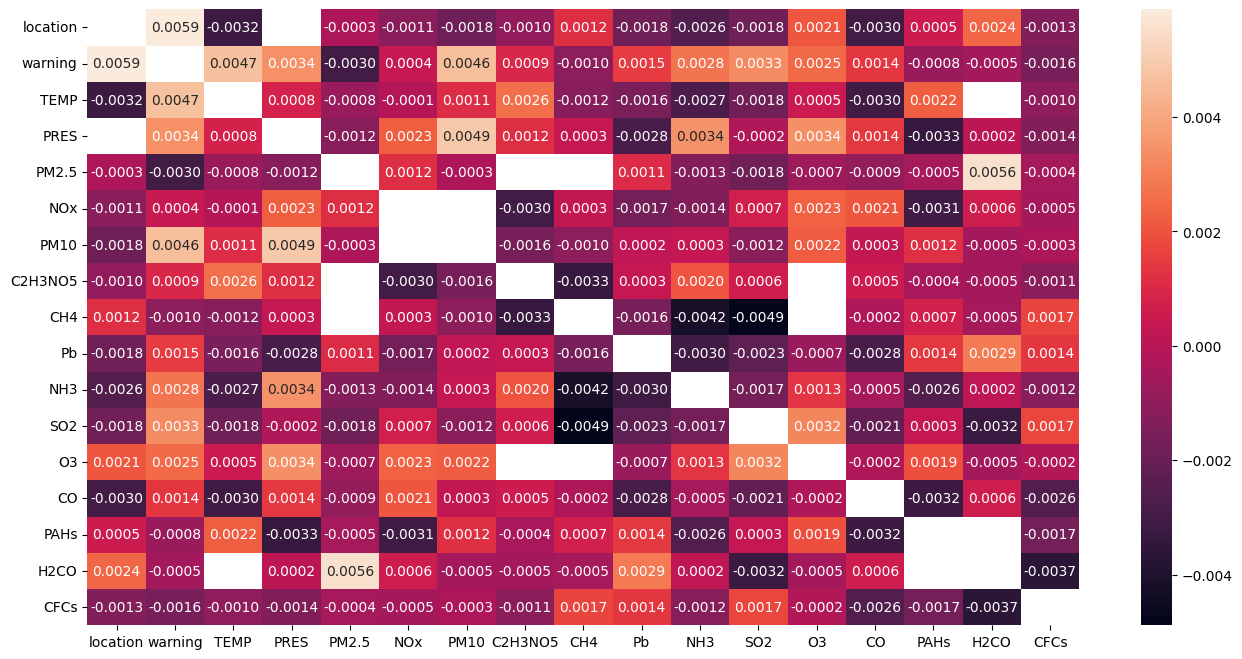

In [9]:
df_ml_dropedNa = replaceNaN(df_ml, 'drop_na')

### Mean

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64


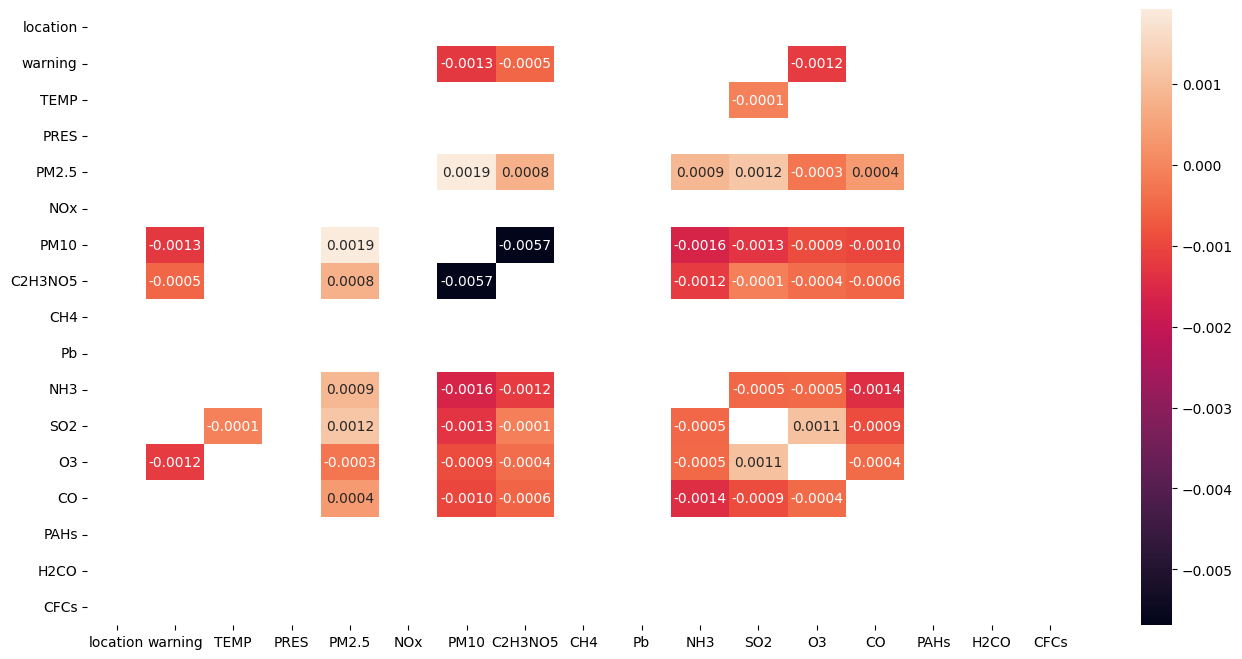

In [10]:
df_ml_na_mean = replaceNaN(df_ml, 'mean')

### Median

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64


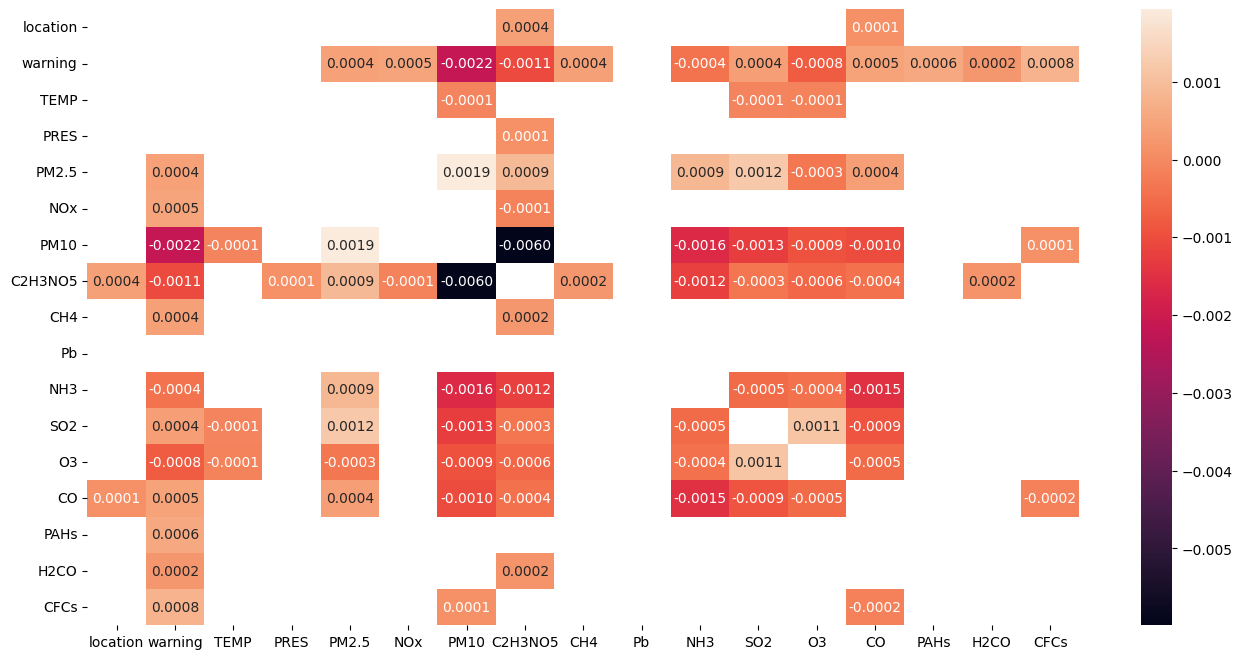

In [11]:
df_ml_na_median = replaceNaN(df_ml, 'median')

### kNN

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64


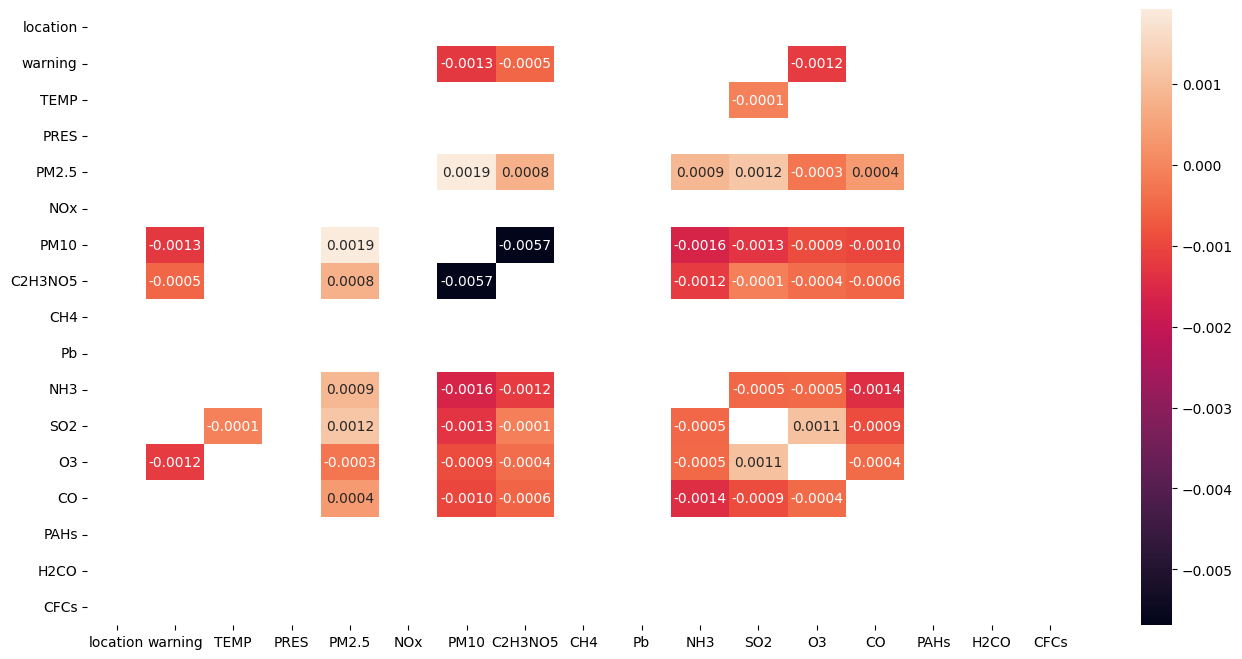

In [12]:
df_ml_na_knn = replaceNaN(df_ml, 'kNN')